In [142]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_1samp, norm
from statsmodels.stats.proportion import proportions_ztest

In [143]:
dataset1 = pd.read_csv("dataset1.csv")
dataset2 = pd.read_csv("dataset2.csv")
dataset1.head()

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


In [144]:
dataset2.head()

,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [145]:
refined_dataset2 = dataset2.copy()
refined_dataset2["obs_start_time"] = pd.to_datetime(refined_dataset2["time"], format="%d/%m/%Y %H:%M")
refined_dataset2.drop(columns=["time"], inplace=True) # we have obs_start_time
refined_dataset2["obs_end_time"] = refined_dataset2["obs_start_time"] + pd.to_timedelta(30, unit="m")
# track observation number
refined_dataset2 = refined_dataset2.reset_index().rename(columns={"index": "obs_num"})
refined_dataset2["obs_num"] += 1

refined_dataset1 = dataset1.copy()
refined_dataset1["start_time"] = pd.to_datetime(refined_dataset1["start_time"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_start"] = pd.to_datetime(refined_dataset1["rat_period_start"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_end"] = pd.to_datetime(refined_dataset1["rat_period_end"], format="%d/%m/%Y %H:%M")

# calculated end time of bat
refined_dataset1["end_time"] = refined_dataset1["start_time"] + pd.to_timedelta(refined_dataset1["bat_landing_to_food"], unit="s")


# calculated the time between rat landing and bat goes to food
refined_dataset1["rat_landing_to_bat_food"] = refined_dataset1["seconds_after_rat_arrival"] + refined_dataset1["bat_landing_to_food"]
refined_dataset1["rat_stay"] = (refined_dataset1["rat_period_end"] - refined_dataset1["rat_period_start"]).dt.total_seconds()

Count of positive rewards 484
Count of negative rewards 423
Count of positive risks 449
Count of negative rewards 458


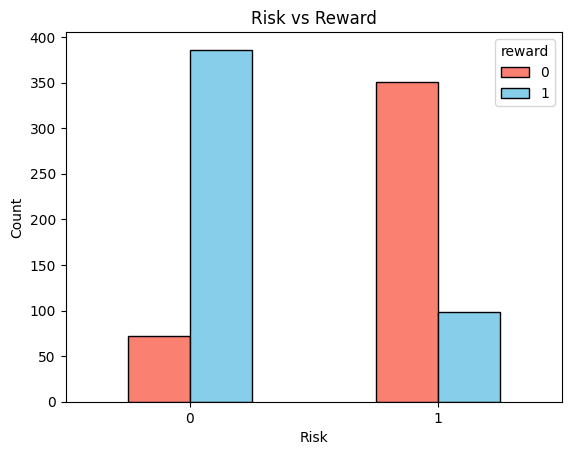

In [146]:
# To check how rewarding it is when taken risk
def risk_vs_reward_show(dataset):
    print("Count of positive rewards", dataset[dataset["reward"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["reward"] == 0].shape[0])
    print("Count of positive risks", dataset[dataset["risk"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["risk"] == 0].shape[0])

    # Count of risks vs rewards
    counts = dataset.groupby(["risk", "reward"]).size().unstack(fill_value=0)    
    counts.plot(kind="bar", color=["salmon", "skyblue"], edgecolor="black", title="Risk vs Reward")
    plt.ylabel("Count")
    plt.xlabel("Risk")
    plt.xticks(rotation=0)
    plt.show()

risk_vs_reward_show(refined_dataset1)

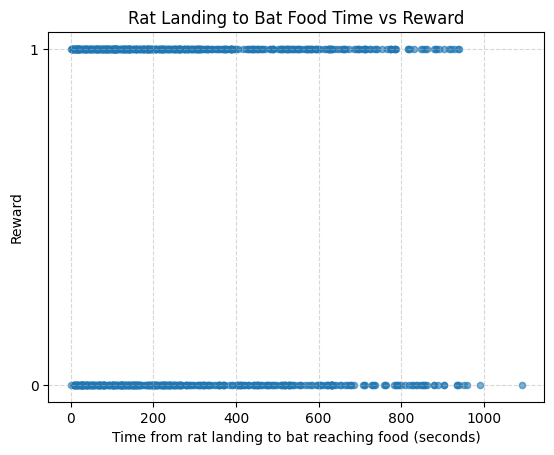

In [147]:
# To see the relationship between time taken from rat landing to bat reaching food and reward
refined_dataset1.plot.scatter(
    x="rat_landing_to_bat_food",
    y="reward",
    alpha=0.6,
    title="Rat Landing to Bat Food Time vs Reward"
)

plt.xlabel("Time from rat landing to bat reaching food (seconds)")
plt.ylabel("Reward")
plt.yticks([0,1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [148]:
refined_dataset1.describe()

,start_time,bat_landing_to_food,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,hours_after_sunset,season,end_time,rat_landing_to_bat_food,rat_stay
count,907,907.000000,907,907,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907,907.000000,907.000000
mean,2018-04-11 20:41:27.056229120,11.713134,2018-04-11 20:36:43.395810304,2018-04-11 20:45:54.178610944,282.877619,0.495039,0.533627,3.800441,5.531863,0.833517,2018-04-11 20:41:38.769363712,294.590752,550.782800
min,2017-12-26 20:57:00,0.010238,2017-12-26 20:53:00,2017-12-26 20:58:00,0.000000,0.000000,0.000000,0.000000,-0.261667,0.000000,2017-12-26 20:57:01,0.047647,0.000000
25%,2018-04-03 23:29:00,1.000000,2018-04-03 23:24:00,2018-04-03 23:40:00,89.500000,0.000000,0.000000,4.000000,3.779028,1.000000,2018-04-03 23:29:25.500000,103.000000,240.000000
50%,2018-04-27 00:28:00,4.000000,2018-04-27 00:24:00,2018-04-27 00:28:00,206.000000,0.000000,1.000000,4.000000,5.622778,1.000000,2018-04-27 00:28:01,223.000000,540.000000
75%,2018-05-01 00:07:30,11.500000,2018-05-01 00:06:00,2018-05-01 00:09:00,446.500000,1.000000,1.000000,5.000000,7.402778,1.000000,2018-05-01 00:07:39,452.000000,780.000000
max,2018-05-31 23:34:00,443.000000,2018-05-31 23:31:00,2018-05-31 23:34:00,949.000000,1.000000,1.000000,5.000000,12.091944,1.000000,2018-05-31 23:34:41,1091.000000,3540.000000
std,NaN,27.644410,NaN,NaN,240.974918,0.500251,0.499143,1.199190,2.414146,0.372719,NaN,243.258921,375.302298


In [149]:
refined_dataset2.describe()

,obs_num,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123,2123
mean,1062.000000,3.083844,5.265426,32.083373,2.445874,1.994442,0.444654,2018-03-19 17:54:20.970324992,2018-03-19 18:24:20.970324992
min,1.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,2017-12-26 16:13:00,2017-12-26 16:43:00
25%,531.500000,2.000000,2.000000,11.000000,1.962206,0.000000,0.000000,2018-02-06 01:03:00,2018-02-06 01:33:00
50%,1062.000000,4.000000,5.000000,27.000000,2.951877,0.000000,0.000000,2018-04-04 05:01:00,2018-04-04 05:31:00
75%,1592.500000,4.000000,8.500000,48.000000,3.105873,0.158333,1.000000,2018-04-30 23:35:00,2018-05-01 00:05:00
max,2123.000000,6.000000,13.500000,178.000000,4.000000,120.000000,17.000000,2018-06-01 05:41:00,2018-06-01 06:11:00
std,613.001631,1.642261,4.076188,25.614431,1.218353,6.793397,1.019195,NaN,NaN


In [150]:
# merge datasets
combined_dataset = refined_dataset1.assign(key=1).merge(
    refined_dataset2.assign(key=1), on="key", suffixes=("_event", "_obs")
).drop("key", axis=1)

# Keep only overlapping intervals
combined_dataset = combined_dataset[
    (combined_dataset["start_time"] <= combined_dataset["obs_end_time"]) &
    (combined_dataset["start_time"] >= combined_dataset["obs_start_time"])
]

combined_dataset.sort_values(by="obs_num", ascending=True)
combined_dataset.head()

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month_event,sunset_time,...,rat_stay,obs_num,month_obs,hours_after_sunset_obs,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time
115,2017-12-30 18:37:00,16.000000,rat,2017-12-30 18:35:00,2017-12-30 18:38:00,108,1,0,0,30/12/2017 16:45,...,180.0,116,0,1.5,36,4.000000,3.283333,1,2017-12-30 18:15:00,2017-12-30 18:45:00
2241,2017-12-30 19:51:00,0.074016,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,17,0,1,0,30/12/2017 16:45,...,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
4364,2017-12-30 19:51:00,4.000000,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,41,0,1,0,30/12/2017 16:45,...,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
6487,2017-12-30 19:52:00,10.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,111,1,0,0,30/12/2017 16:45,...,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
8610,2017-12-30 19:54:00,15.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,194,1,0,0,30/12/2017 16:45,...,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00


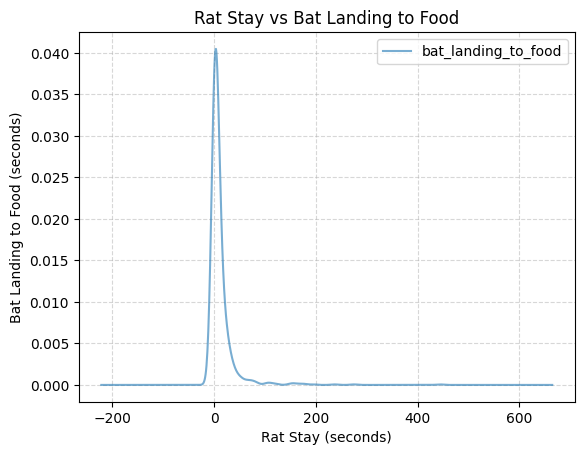

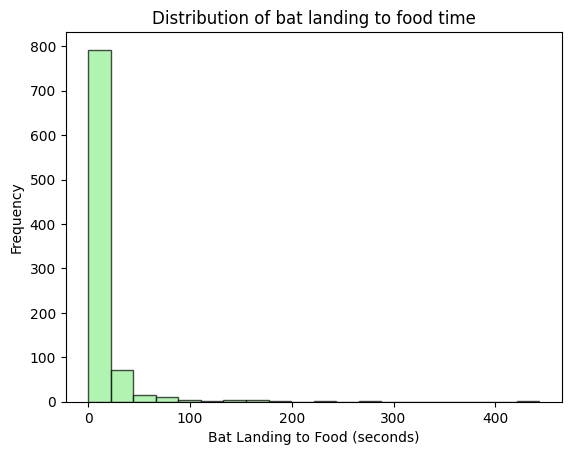

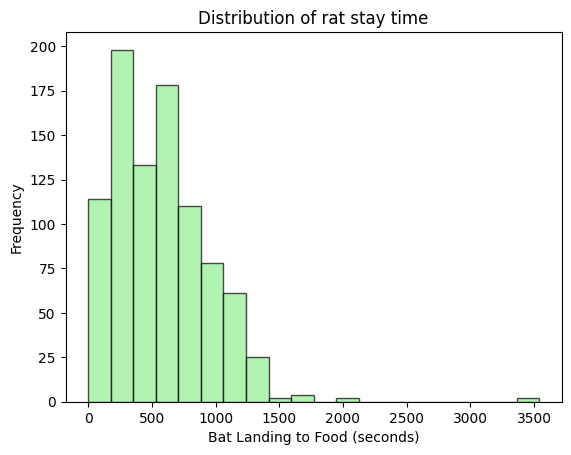

In [151]:
# Compare how the bat landing to food time with the rat stay duration
refined_dataset1.plot.kde(
    x="rat_stay",
    y="bat_landing_to_food",
    alpha=0.6,
    title="Rat Stay vs Bat Landing to Food"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Bat Landing to Food (seconds)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

refined_dataset1["bat_landing_to_food"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of bat landing to food time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

refined_dataset1["rat_stay"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of rat stay time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

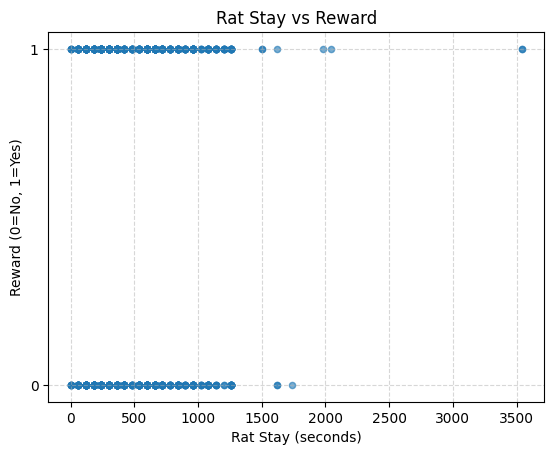

In [152]:
# 1. Scatter plot: rat_stay vs reward
refined_dataset1.plot.scatter(
    x="rat_stay",
    y="reward",
    alpha=0.6,
    title="Rat Stay vs Reward"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Reward (0=No, 1=Yes)")
plt.yticks([0, 1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

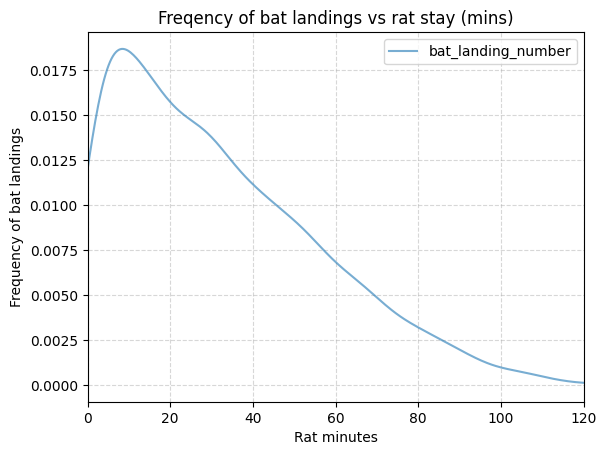

In [153]:
# To see the relationship between number of bats and rat stay time
refined_dataset2.plot.kde(
    x="rat_minutes",
    y="bat_landing_number",
    alpha=0.6,
    title="Freqency of bat landings vs rat stay (mins)"
)

# Limit to observed data range only
plt.xlim(refined_dataset2["rat_minutes"].min(),
         refined_dataset2["rat_minutes"].max())

plt.xlabel("Rat minutes")
plt.ylabel("Frequency of bat landings")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [154]:
# Create food scarcity indicator
refined_dataset2['food_scarcity'] = pd.cut(refined_dataset2['food_availability'], 
                                          bins=3, labels=['Scarce', 'Moderate', 'Abundant'])

In [155]:
refined_dataset2

,obs_num,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time,food_scarcity
0,1,0,-0.5,20,4.000000,0.0,0,2017-12-26 16:13:00,2017-12-26 16:43:00,Abundant
1,2,0,0.0,28,4.000000,0.0,0,2017-12-26 16:43:00,2017-12-26 17:13:00,Abundant
2,3,0,0.5,25,4.000000,0.0,0,2017-12-26 17:13:00,2017-12-26 17:43:00,Abundant
3,4,0,1.0,71,4.000000,0.0,0,2017-12-26 17:43:00,2017-12-26 18:13:00,Abundant
4,5,0,1.5,44,3.753857,0.0,0,2017-12-26 18:13:00,2017-12-26 18:43:00,Abundant
...,...,...,...,...,...,...,...,...,...,...
2118,2119,6,8.0,20,1.000000,0.0,0,2018-06-01 03:41:00,2018-06-01 04:11:00,Scarce
2119,2120,6,8.5,7,1.000000,0.0,0,2018-06-01 04:11:00,2018-06-01 04:41:00,Scarce
2120,2121,6,9.0,6,1.000000,0.0,0,2018-06-01 04:41:00,2018-06-01 05:11:00,Scarce
2121,2122,6,9.5,7,1.000000,0.0,0,2018-06-01 05:11:00,2018-06-01 05:41:00,Scarce


<Axes: title={'center': 'Rat activity throughout the night'}, xlabel='Hours After Sunset', ylabel='Number of Rat Arrivals'>

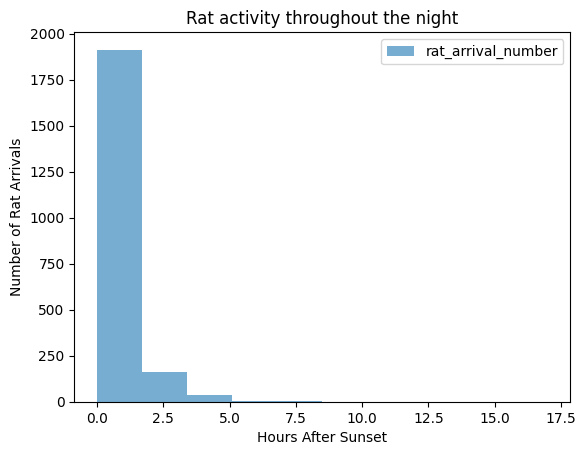

In [156]:
refined_dataset2.plot.hist(
    x='hours_after_sunset', 
    y='rat_arrival_number', 
    alpha=0.6,
    title='Rat activity throughout the night',
    xlabel='Hours After Sunset',
    ylabel='Number of Rat Arrivals'
)

<Axes: title={'center': 'Food available and Rat stay time'}, xlabel='Food availability', ylabel='Rat stay time'>

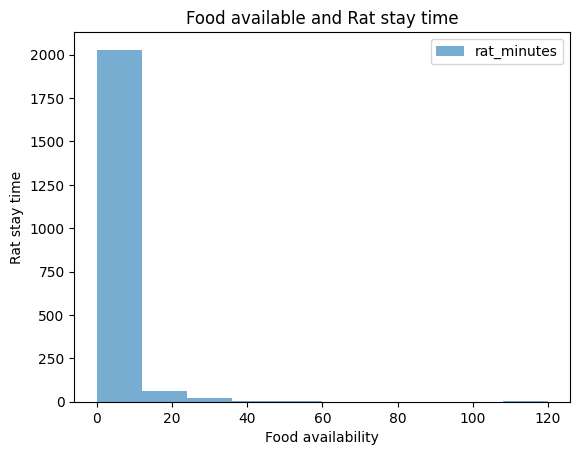

In [157]:
refined_dataset2.plot.hist(
    x='food_availability', 
    y='rat_minutes', 
    alpha=0.6,
    title='Food available and Rat stay time',
    xlabel='Food availability',
    ylabel='Rat stay time'
)

<Axes: title={'center': 'Bat landing number vs rat arrivals'}, xlabel='Bat landing number', ylabel='Rat arrivals'>

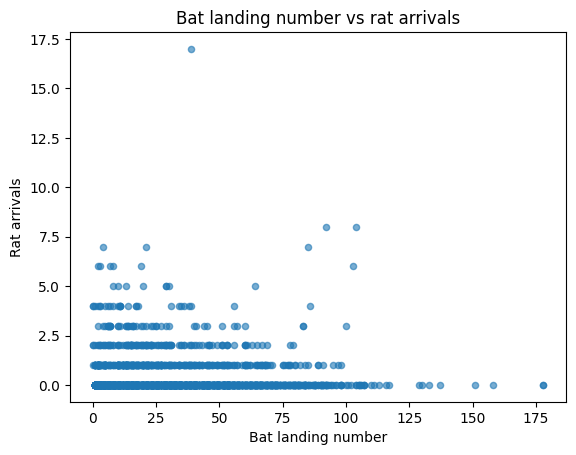

In [158]:
refined_dataset2.plot.scatter(
    x='bat_landing_number', 
    y='rat_arrival_number', 
    alpha=0.6, 
    title='Bat landing number vs rat arrivals',
    xlabel='Bat landing number',
    ylabel='Rat arrivals'
)

In [159]:
# Inferential Analysis
# One sample T test using bat_landing_to_food variable

print("\nHYPOTHESIS:")
print("H0: Bats do NOT perceive rats as predators (no increased vigilance)")
print("H1: Bats DO perceive rats as predators (increased vigilance/avoidance)")
print("ONE-SAMPLE T-TEST - BAT ALERTNESS ANALYSIS\n")

# Remove missing values
bat_landing_to_food_times = refined_dataset1['bat_landing_to_food'].dropna()
n1 = len(bat_landing_to_food_times)
sample_mean = bat_landing_to_food_times.mean()
sample_std = bat_landing_to_food_times.std()

print(f"Sample size: {n1}")
print(f"Sample mean: {sample_mean:.3f} seconds")
print(f"Sample standard deviation: {sample_std:.3f} seconds")

# Hypothesis: If bats perceive rats as predators, they should be more alert
# We test against a baseline of 10 seconds
baseline = 10.0  # seconds - expected time without predator threat

print(f"\nTesting against baseline of {baseline} seconds")
print(f"H0: μ = {baseline} (no predator perception)")
print(f"H1: μ > {baseline} (predator perception increases vigilance)")

t_stats, p_val = ttest_1samp(bat_landing_to_food_times, baseline, alternative='greater')

print("\nComputing t* ...")
print("t-statistic (t*): %.2f" % t_stats)

print("\nConclusion:")
if p_val < 0.05:
    print("We reject the null hypothesis.")
    print("This suggests bats may perceive rats as predators.")
else:
    print("We accept the null hypothesis.")
    print("This suggests bats may not perceive rats as predators.")


HYPOTHESIS:
H0: Bats do NOT perceive rats as predators (no increased vigilance)
H1: Bats DO perceive rats as predators (increased vigilance/avoidance)
ONE-SAMPLE T-TEST - BAT ALERTNESS ANALYSIS

Sample size: 907
Sample mean: 11.713 seconds
Sample standard deviation: 27.644 seconds

Testing against baseline of 10.0 seconds
H0: μ = 10.0 (no predator perception)
H1: μ > 10.0 (predator perception increases vigilance)

Computing t* ...
t-statistic (t*): 1.87

Conclusion:
We reject the null hypothesis.
This suggests bats may perceive rats as predators.


In [ ]:
# Inferential Analysis
# Z-TEST FOR PROPORTIONS - RISK-TAKING vs SUCCESS

# Get data for risk-takers and risk-avoiders
risk_takers = refined_dataset1[refined_dataset1['risk'] == 1]
risk_avoiders = refined_dataset1[refined_dataset1['risk'] == 0]

n_risk_takers = len(risk_takers)
n_risk_avoiders = len(risk_avoiders)

# Success rates (reward = 1)
success_risk_takers = risk_takers['reward'].sum()
success_risk_avoiders = risk_avoiders['reward'].sum()

p_risk_takers = success_risk_takers / n_risk_takers if n_risk_takers > 0 else 0
p_risk_avoiders = success_risk_avoiders / n_risk_avoiders if n_risk_avoiders > 0 else 0

print(f"Risk-takers: {success_risk_takers}/{n_risk_takers} = {p_risk_takers:.3f} success rate")
print(f"Risk-avoiders: {success_risk_avoiders}/{n_risk_avoiders} = {p_risk_avoiders:.3f} success rate")

# successes and sample sizes
successes = [success_risk_takers, success_risk_avoiders]
samples = [n_risk_takers, n_risk_avoiders]

# two-sided test
z_statistic, p_value_z = proportions_ztest(successes, samples, alternative="two-sided")

print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value (two-tailed): {p_value_z:.4f}")

if p_value_z < 0.05:
    if p_risk_takers > p_risk_avoiders:
        print("CONCLUSION: risk-takers have significantly HIGHER success rates!")
    else:
        print("CONCLUSION: risk-avoiders have significantly HIGHER success rates!")
else:
    print("CONCLUSION: No significant difference in success rates.")

Risk-takers: 98/449 = 0.218 success rate
Risk-avoiders: 386/458 = 0.843 success rate
Z-statistic: -18.8504
P-value (two-tailed): 0.0000
CONCLUSION: risk-avoiders have significantly HIGHER success rates!
